In [1]:
import sys

ABS_PATH = '/mnt/arquivos_linux/1_semestre/Lotufo/caption_medical_images'

sys.path.insert(0,ABS_PATH)

from data_folder.medical_datasets import RocoDataset
from models.EncoderDecoder import EncoderDecoder
import matplotlib.pyplot as plt
import torch
from constants import *
import yaml



with open(f'{ABS_PATH}/config_models/config_decoder.yaml', 'r') as file:
    parameters_dec = yaml.safe_load(file)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

model = EncoderDecoder()
#'model_base_line_26_jun.pt'
load_dict = torch.load("../weight_models/model_base_line_26_jun.pt")
model.load_state_dict(load_dict['model_state_dict'])

Using cpu


<All keys matched successfully>

In [2]:

# model.to(device)

roco_path = f"{ABS_PATH}/roco-dataset"

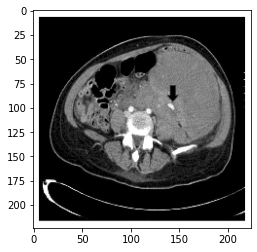

In [36]:
train_loader = RocoDataset(roco_path=roco_path,
                           mode="train",
                           caption_max_length=parameters_dec['max_seq_length'])

img, _, caption_target, _, _ = train_loader[23]

plt.imshow(img[0,:,:],cmap='gray')

In [37]:
from transformers import BertTokenizer, AutoTokenizer

tz = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')

In [38]:
caption_target

tensor([ 7314, 10878,  1685,   188,  7602,  2187,   864,  7314, 10878,  1685,
          102,     0])

In [39]:
tz.decode(tz.encode(''))

'[CLS] [SEP]'

In [40]:
torch.LongTensor(tz.encode('') + 10*[0])

tensor([101, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [41]:
#
logits = model(img.unsqueeze(0), torch.LongTensor(tz.encode('') + 10*[0]).unsqueeze(0))

In [42]:
logits = logits.reshape(-1, logits.shape[-1])

In [43]:
import numpy as np

vector_predicted = torch.argmax(logits,axis=1)

In [44]:
vector_predicted

tensor([111,   0, 578,   0, 578, 125,   0, 578,   0,   0, 102,   0])

In [45]:
tz.decode(vector_predicted)

'the [PAD] - [PAD] - of [PAD] - [PAD] [PAD] [SEP] [PAD]'

In [46]:
tz.decode(caption_target)

'ct axial image with iv contrast : ct axial image [SEP] [PAD]'

In [50]:
max_output_tokens = 20
prompt = ''
model.eval()

context_size = 12

for _ in range(max_output_tokens):
    input_ids = tz.encode(prompt)
    input_ids_truncated = input_ids[-context_size:]  # Usamos apenas os últimos <context_size> tokens como entrada para o modelo.
    logits = model(img.unsqueeze(0),torch.LongTensor([input_ids_truncated]).unsqueeze(0))
    # Ao usarmos o argmax, a saída do modelo em cada passo é o token de maior probabilidade.
    # Isso se chama decodificação gulosa (greedy decoding).
    predicted_id = torch.argmax(logits).item()
    input_ids += [predicted_id]  # Concatenamos a entrada com o token escolhido nesse passo.
    prompt = tokenizer.decode(input_ids)
    print(prompt)

RuntimeError: The size of tensor a (2) must match the size of tensor b (12) at non-singleton dimension 3